# Plan: Hybrid Visual Product Search

## Objective
Build a robust product search engine that leverages both visual features and semantic understanding to retrieve relevant products from the **Amazon Berkeley Objects (ABO)** dataset.

## Architecture: Two-Model Approach

We will implement a **Query Expansion** strategy using a multimodal ensemble. This addresses the limitations of pure visual search (which misses semantic meaning) and pure text search (which misses visual style).

### 1. Model 1: Image Captioner (The "Translator")
*   **Role:** Converts the visual content of the query image into a rich textual description.
*   **Model:** `Salesforce/blip-image-captioning-base` (or similar VLM like LLaVA/InstructBLIP).
*   **Why?** CLIP sometimes misses specific details (brand names, specific counts, nuanced attributes). A captioner acts as a "semantic bridge."
*   **Output:** Text string (e.g., *"A stainless steel travel coffee mug with a black handle and a Starbucks logo"*).

### 2. Model 2: Dual Encoder (The "Embedder")
*   **Role:** Maps inputs into a shared vector space for similarity search.
*   **Model:** `openai/clip-vit-base-patch32`.
*   **Process:**
    *   **Branch A (Visual):** Encode the original **Image** into a vector $V_{img}$.
    *   **Branch B (Text):** Encode the **Generated Description** into a vector $V_{txt}$.
    *   **Fusion:** Combine these vectors (e.g., Mean Pooling: $V_{final} = \frac{V_{img} + V_{txt}}{2}$) to get a robust query representation.

### 3. Retrieval System
*   **Index:** A vector database (FAISS or simple Tensor search) containing CLIP embeddings of the ABO catalog images.
*   **Search:** Compute Cosine Similarity between $V_{final}$ and the Catalog Index.

## Implementation Steps
1.  **Data Loading:** parsing the ABO metadata and loading images.
2.  **Indexing:** Generate CLIP embeddings for a subset of the ABO catalog.
3.  **Pipeline Construction:**
    *   Define `generate_caption(image)` function.
    *   Define `get_embedding(image, text)` function.
4.  **Search Logic:** Implement the retrieval and ranking.
5.  **Evaluation:** Qualitative testing with sample images.

In [37]:
import os
import pandas as pd
from pathlib import Path
from PIL import Image
import gzip
import json

# Set the path to the dataset relative to the notebook
# The notebook is in 'two-tower/', data is in 'data/abo/' at the project root.
DATA_ROOT = Path("../data/abo")

# Verify the path exists
if not DATA_ROOT.exists():
    print(f"Warning: {DATA_ROOT} does not exist. Check your current working directory.")
    print(f"Current Directory: {os.getcwd()}")
else:
    print(f"Data Root found at: {DATA_ROOT.resolve()}")

Data Root found at: /Users/hrishikesh/Developer/visual-product-search/data/abo


In [38]:
# 1. Load Listings Metadata (Product Info)
# The listings are split into multiple JSON.GZ files.
# We will iterate through all of them to get the full catalog.
listings_dir = DATA_ROOT / "listings/metadata"
listing_files = sorted(listings_dir.glob("listings_*.json.gz"))

if not listing_files:
    print("No listing files found! Check your path.")
    df_listings = pd.DataFrame()
else:
    print(f"Found {len(listing_files)} listing files.")
    dfs = []
    for l_path in listing_files:
        print(f"Loading {l_path.name}...", end="\r")
        try:
            df = pd.read_json(l_path, lines=True)
            dfs.append(df)
        except Exception as e:
            print(f"\nError loading {l_path.name}: {e}")

    if dfs:
        df_listings = pd.concat(dfs, ignore_index=True)
        print(f"\nSuccessfully loaded {len(df_listings)} total products.")
        display(df_listings.head(2))
    else:
        print("Failed to load any listings.")

# 2. Load Image Metadata (Paths)
# This CSV maps image_id to the relative path of the image file.
images_meta_path = DATA_ROOT / "images/metadata/images.csv.gz"

print(f"\nLoading image metadata from: {images_meta_path}")
try:
    df_images = pd.read_csv(images_meta_path)
    print(f"Loaded {len(df_images)} image records.")
    display(df_images.head(2))
except Exception as e:
    print(f"Error loading image metadata: {e}")

Found 16 listing files.
Loading listings_f.json.gz...
Successfully loaded 147702 total products.


brand  \
0      [{'language_tag': 'nl_NL', 'value': 'find.'}]   
1  [{'language_tag': 'es_MX', 'value': 'AmazonBas...   

                                        bullet_point  \
0  [{'language_tag': 'nl_NL', 'value': 'Schoen in...   
1  [{'language_tag': 'es_MX', 'value': 'White Pow...   

                                               color     item_id  \
0  [{'language_tag': 'nl_NL', 'value': 'Veelkleur...  B06X9STHNG   
1  [{'language_tag': 'es_MX', 'value': 'White Pow...  B07P8ML82R   

                                           item_name  \
0  [{'language_tag': 'nl_NL', 'value': 'Amazon-me...   
1  [{'language_tag': 'es_MX', 'value': '22" Botto...   

                                      model_name  \
0  [{'language_tag': 'nl_NL', 'value': '37753'}]   
1                                            NaN   

                   model_number         model_year             product_type  \
0       [{'value': '12-05-04'}]  [{'value': 2017}]     [{'value': 'SHOES'}]   
1  [{'value': 'AB5013-R22-10'}]                NaN  [{'value': 'HARDWARE'}]   

                                               style  ...  \
0  [{'language_tag': 'nl_NL', 'value': 'Gesloten-...  ...   
1   [{'language_tag': 'es_MX', 'value': '10 pares'}]  ...   

                                         item_weight material fabric_type  \
0                                                NaN      NaN         NaN   
1  [{'normalized_value': {'unit': 'pounds', 'valu...      NaN         NaN   

  color_code product_description spin_id 3dmodel_id pattern finish_type  \
0        NaN                 NaN     NaN        NaN     NaN         NaN   
1        NaN                 NaN     NaN        NaN     NaN         NaN   

  item_shape  
0        NaN  
1        NaN  

[2 rows x 28 columns]


Loading image metadata from: ../data/abo/images/metadata/images.csv.gz
Loaded 398212 image records.


image_id  height  width             path
0  010-mllS7JL     106    106  14/14fe8812.jpg
1  01dkn0Gyx0L     122    122  da/daab0cad.jpg

In [39]:
# 3. Filter for Downloaded Images (Since we only downloaded a subset)
# Function to check if image file exists
def get_full_path(relative_path):
    return DATA_ROOT / "images/original" / relative_path

# Add full path column
df_images['full_path'] = df_images['path'].apply(get_full_path)

# Filter: keep only rows where the file exists on disk
# This is crucial because we did a partial download (approx 5GB)
print("Filtering for existing image files...")
df_available = df_images[df_images['full_path'].apply(lambda x: x.exists())].copy()

print(f"Total images in metadata: {len(df_images)}")
print(f"Images found on disk: {len(df_available)}")
display(df_available.head())

# 4. Merge with Product Info
# In ABO, listings usually link to images via 'main_image_id' or similar.
# Let's inspect columns to find the link.
print("Listing columns:", df_listings.columns.tolist())
if 'main_image_id' in df_listings.columns:
    merge_key = 'main_image_id'
elif 'image_id' in df_listings.columns:
    merge_key = 'image_id'
else:
    # Fallback: Check if 'item_id' matches
    merge_key = None
    print("Warning: Could not automatically detect image ID column in listings.")

if merge_key:
    # Merge listings with available images
    df_merged = pd.merge(df_listings, df_available, left_on=merge_key, right_on='image_id', how='inner')
    print(f"Products with available images: {len(df_merged)}")
    display(df_merged[['item_id', 'item_name', 'path', 'full_path']].head())
else:
    df_merged = df_available # Fallback for now

Filtering for existing image files...
Total images in metadata: 398212
Images found on disk: 49615


image_id  height  width             path  \
0   010-mllS7JL     106    106  14/14fe8812.jpg   
18  21+KGgoGHkL     500    375  12/12bdb2fc.jpg   
24  21+X-uttvbL     300    300  1c/1c58212f.jpg   
30  21+jwTc3JYL     500    375  16/165b2093.jpg   
37  21-6JdQxZNL     500    375  10/1041934c.jpg   

                                      full_path  
0   ../data/abo/images/original/14/14fe8812.jpg  
18  ../data/abo/images/original/12/12bdb2fc.jpg  
24  ../data/abo/images/original/1c/1c58212f.jpg  
30  ../data/abo/images/original/16/165b2093.jpg  
37  ../data/abo/images/original/10/1041934c.jpg

Listing columns: ['brand', 'bullet_point', 'color', 'item_id', 'item_name', 'model_name', 'model_number', 'model_year', 'product_type', 'style', 'main_image_id', 'other_image_id', 'item_keywords', 'country', 'marketplace', 'domain_name', 'node', 'item_dimensions', 'item_weight', 'material', 'fabric_type', 'color_code', 'product_description', 'spin_id', '3dmodel_id', 'pattern', 'finish_type', 'item_shape']
Products with available images: 18138


item_id                                          item_name  \
0  B0896LJNLH  [{'language_tag': 'en_US', 'value': 'AmazonBas...   
1  B07J4HXTQH  [{'language_tag': 'de_DE', 'value': 'AmazonBas...   
2  B07T9TND12  [{'language_tag': 'en_IN', 'value': 'Amazon Br...   
3  B01N5XROXR  [{'language_tag': 'en_AE', 'value': 'Amazon Br...   
4  B07TJVSBV1  [{'language_tag': 'en_IN', 'value': 'Amazon Br...   

              path                                    full_path  
0  07/075e5d67.jpg  ../data/abo/images/original/07/075e5d67.jpg  
1  1e/1e39ce5a.jpg  ../data/abo/images/original/1e/1e39ce5a.jpg  
2  04/040353c9.jpg  ../data/abo/images/original/04/040353c9.jpg  
3  14/14d129a0.jpg  ../data/abo/images/original/14/14d129a0.jpg  
4  00/0055d71a.jpg  ../data/abo/images/original/00/0055d71a.jpg

Product: [{'language_tag': 'en_US', 'value': 'AmazonBasics by Disney Minnie Mouse Purple Love Bed Sheet Set, Twin'}]


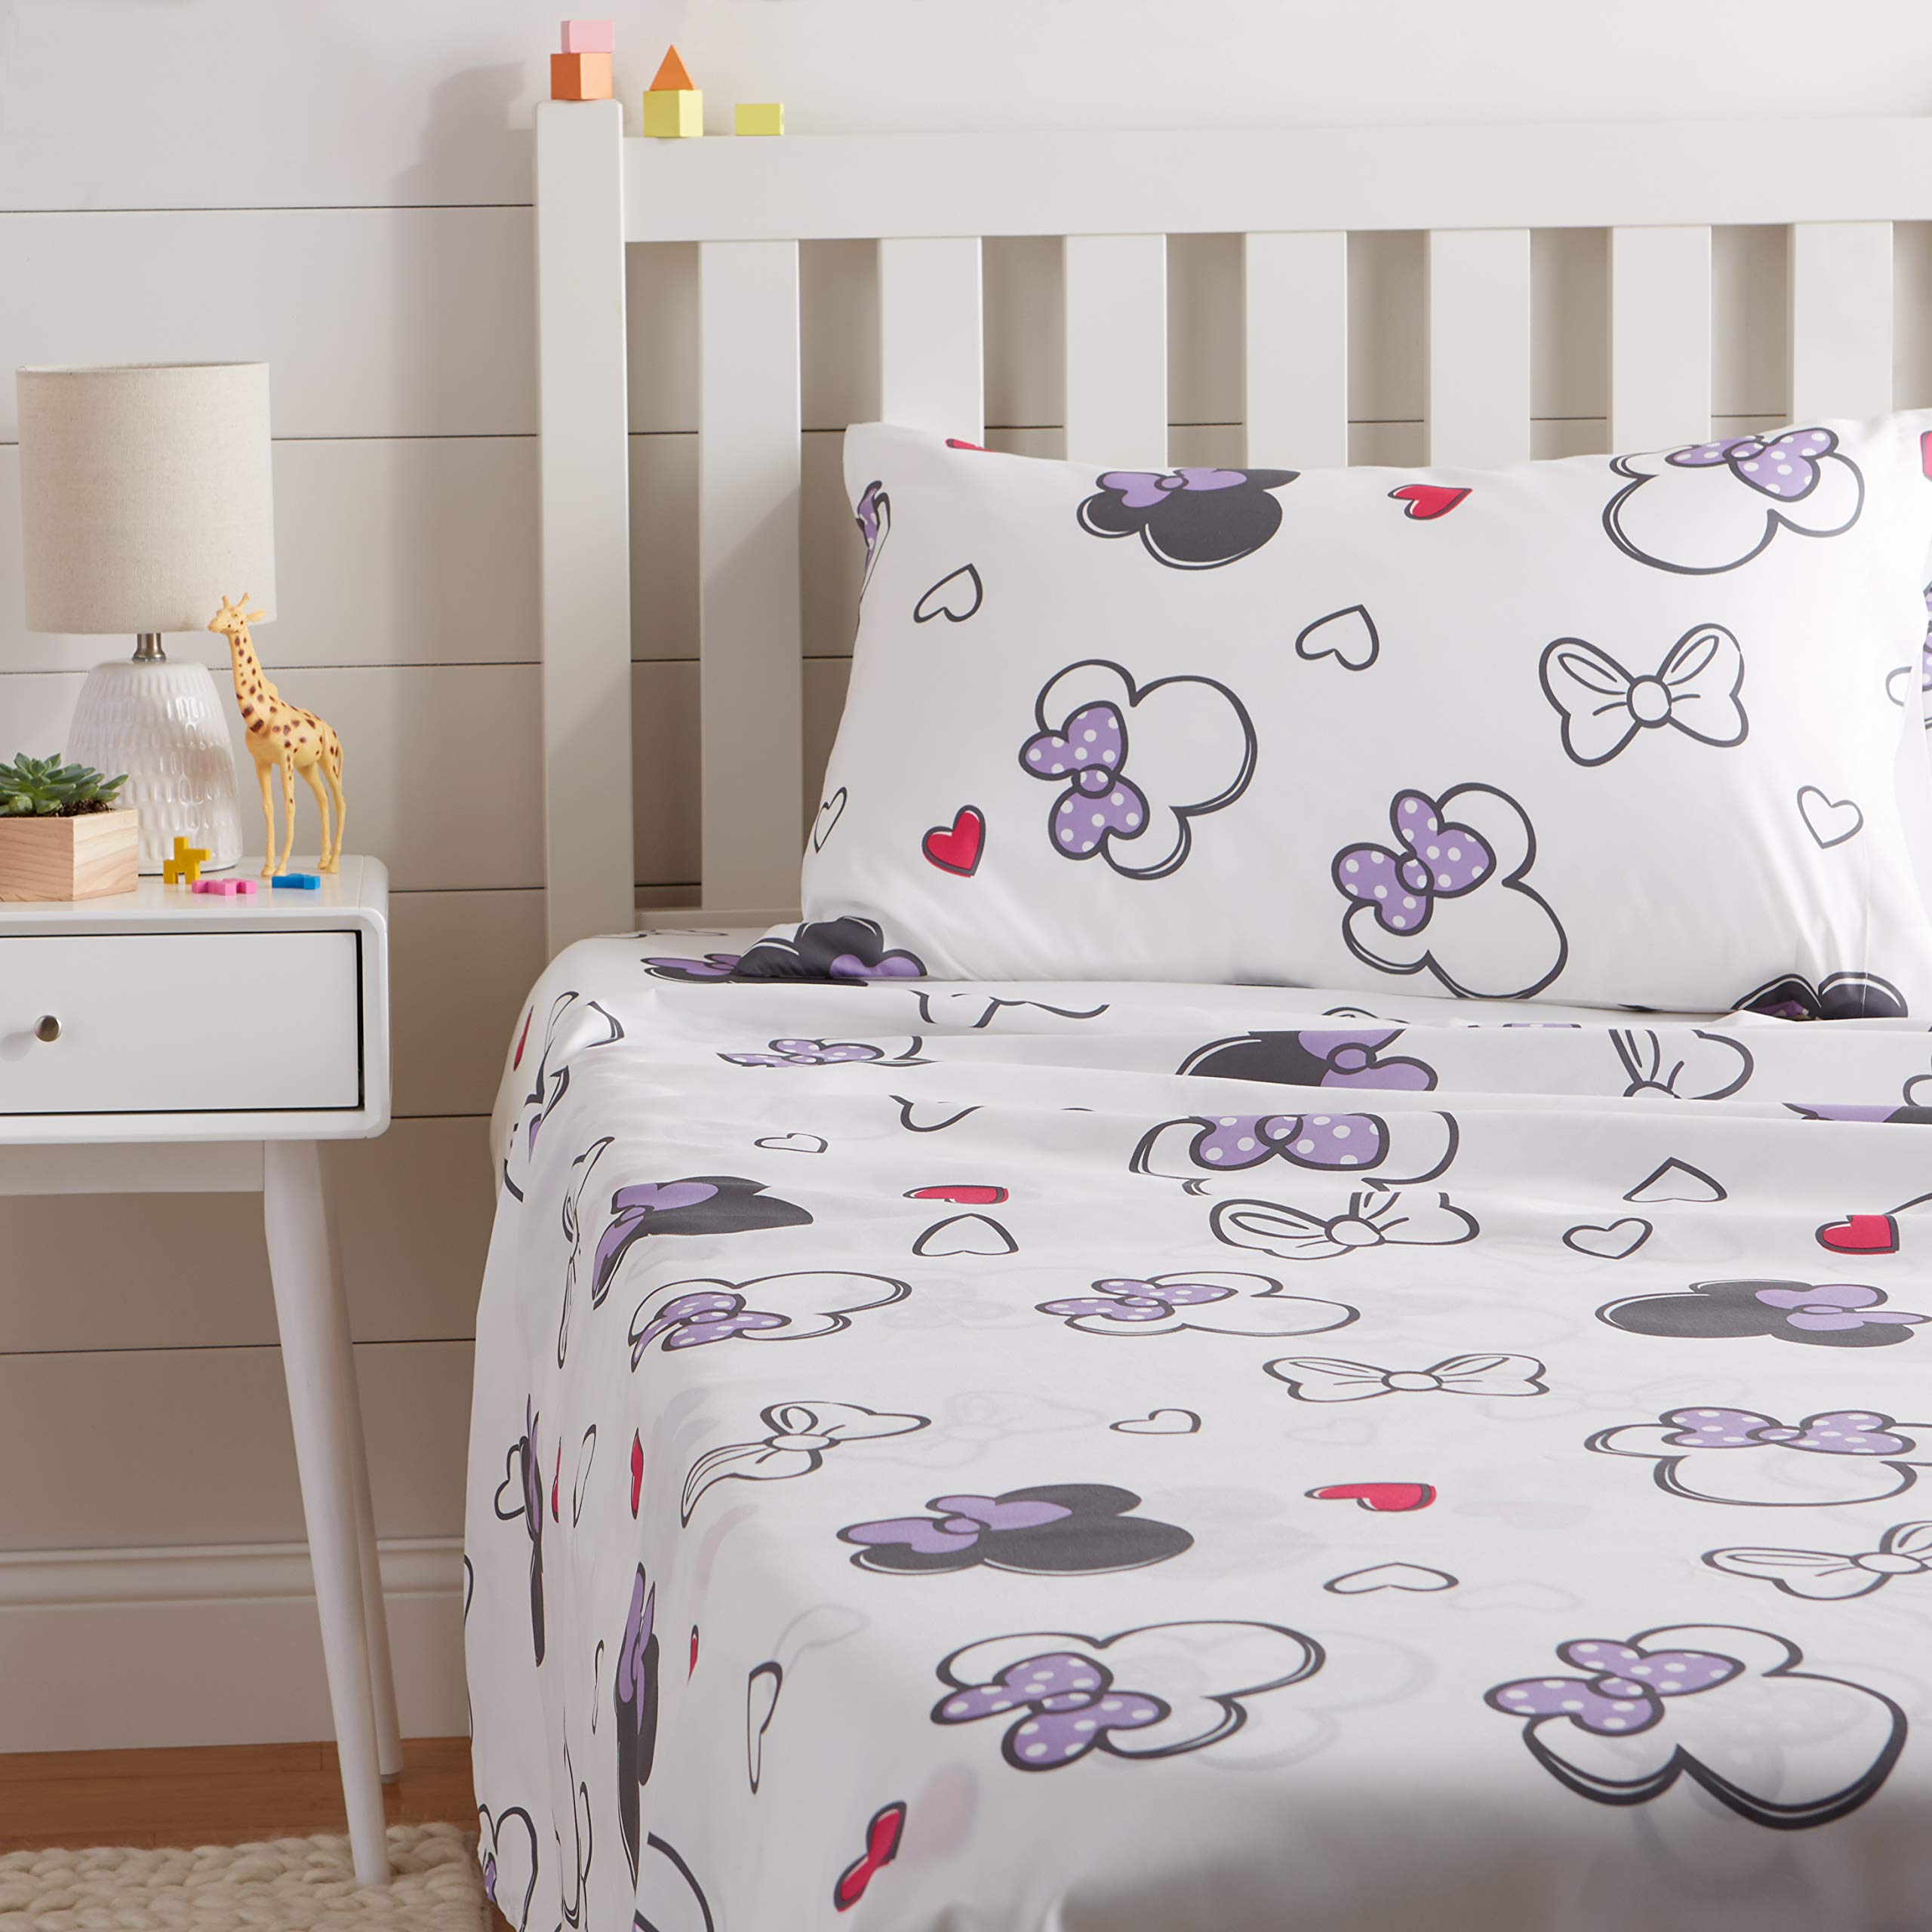

In [40]:
# 5. Visualize a Sample
# Take a random sample from our verified dataset
if not df_merged.empty:
    sample = df_merged.sample(1).iloc[0]
    
    img_path = sample['full_path']
    if 'item_name' in sample:
        title = sample['item_name']
    else:
        title = "Unknown Product"
        
    print(f"Product: {title}")
    # print(f"Path: {img_path}") # Optional debugging
    
    try:
        display(Image.open(img_path))
    except Exception as e:
        print(f"Error opening image: {e}")
else:
    print("No images found to display. Did you run the download script?")

# Step 2: Indexing (Generating Embeddings)
We will now generate vector embeddings for our product images using the CLIP model (`openai/clip-vit-base-patch32`). 
These embeddings will serve as our search index.

### Prerequisites
Ensure you have `torch` and `transformers` installed:
```bash
pip install torch transformers tqdm
```

In [41]:
import torch
from transformers import CLIPModel, CLIPProcessor
from tqdm.auto import tqdm
import numpy as np

# 1. Load CLIP Model
model_id = "openai/clip-vit-base-patch32"
print(f"Loading CLIP model: {model_id}...")

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

try:
    model = CLIPModel.from_pretrained(model_id).to(device)
    processor = CLIPProcessor.from_pretrained(model_id)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")

Loading CLIP model: openai/clip-vit-base-patch32...
Using device: mps


Loading weights: 100%|██████████| 398/398 [00:00<00:00, 2228.26it/s, Materializing param=visual_projection.weight]                                
CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
text_model.embeddings.position_ids   | UNEXPECTED |  | 
vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Model loaded successfully.


In [42]:
# 2. Generate Embeddings (Batched)
# We will process images in batches to avoid memory issues.
BATCH_SIZE = 32

def generate_image_embeddings(image_paths, batch_size=32):
    all_embeddings = []
    
    # Process in chunks
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Encoding Images"):
        batch_paths = image_paths[i:i + batch_size]
        valid_images = []
        valid_indices = []
        
        # Load images (handle potential errors)
        for idx, p in enumerate(batch_paths):
            try:
                img = Image.open(p).convert("RGB")
                valid_images.append(img)
                valid_indices.append(idx)
            except Exception as e:
                print(f"Skipping error image {p}: {e}")
                
        if not valid_images:
            continue
            
        # Preprocess and Forward Pass
        inputs = processor(images=valid_images, return_tensors="pt", padding=True).to(device)
        
        with torch.no_grad():
            outputs = model.get_image_features(**inputs)
            
            # Handle different output types (Tensor vs BaseModelOutput)
            if isinstance(outputs, torch.Tensor):
                image_features = outputs
            else:
                if hasattr(outputs, 'image_embeds'):
                    image_features = outputs.image_embeds
                elif hasattr(outputs, 'pooler_output'):
                    image_features = outputs.pooler_output
                else:
                    image_features = outputs[0]
            
            # Normalize embeddings for cosine similarity
            embeddings = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
            embeddings = embeddings.cpu().numpy()
            
        all_embeddings.append(embeddings)

    if all_embeddings:
        return np.vstack(all_embeddings)
    else:
        return np.array([])

# Run on our dataset
# We'll use a subset if the dataset is huge just for testing, or full if comfortable.
# Let's take 'full_path' column from our merged dataframe.

print(f"Generating embeddings for {len(df_merged)} images...")

# Extract paths
image_paths = df_merged['full_path'].tolist()

# Let's limit to 1000 for quick testing if user wants (uncomment to limit)
# image_paths = image_paths[:1000] 

if image_paths:
    image_embeddings = generate_image_embeddings(image_paths, BATCH_SIZE)
    print(f"Embeddings Shape: {image_embeddings.shape}")
    
    # Save embeddings for later use?
    # np.save("abo_image_embeddings.npy", image_embeddings)
else:
    print("No images to process.")

Generating embeddings for 18138 images...


Encoding Images: 100%|██████████| 567/567 [04:28<00:00,  2.11it/s]

Embeddings Shape: (18138, 512)


# Step 3: Pipeline Construction (Hybrid Search)
Now we build the two-model pipeline:
1.  **Image Captioner (BLIP):** To generate a text description of the query image.
2.  **Embedder (CLIP):** To generate embeddings for both the image and the generated text.

We will combine these embeddings to form a "Hybrid Query" that captures both visual style and semantic content.

In [43]:
from transformers import BlipProcessor, BlipForConditionalGeneration

# 1. Load Captioning Model (BLIP)
blip_model_id = "Salesforce/blip-image-captioning-base"
print(f"Loading BLIP model: {blip_model_id}...")

try:
    blip_processor = BlipProcessor.from_pretrained(blip_model_id)
    blip_model = BlipForConditionalGeneration.from_pretrained(blip_model_id).to(device)
    print("BLIP model loaded successfully.")
except Exception as e:
    print(f"Error loading BLIP model: {e}")

Loading BLIP model: Salesforce/blip-image-captioning-base...


Loading weights: 100%|██████████| 473/473 [00:00<00:00, 2268.77it/s, Materializing param=vision_model.post_layernorm.weight]                                       
The tied weights mapping and config for this model specifies to tie text_decoder.cls.predictions.bias to text_decoder.cls.predictions.decoder.bias, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie text_decoder.bert.embeddings.word_embeddings.weight to text_decoder.cls.predictions.decoder.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
BlipForConditionalGeneration LOAD REPORT from: Salesforce/blip-image-captioning-base
Key                                       | Status     |  | 
------------------------------------------+------------+--+-
text_deco

BLIP model loaded successfully.


In [44]:
# 2. Define Helper Functions

def generate_caption(image):
    """
    Generates a text description for a given PIL Image.
    """
    inputs = blip_processor(image, return_tensors="pt").to(device)
    
    # Generate caption
    with torch.no_grad():
        out = blip_model.generate(**inputs, max_new_tokens=50)
    
    caption = blip_processor.decode(out[0], skip_special_tokens=True)
    return caption

def get_hybrid_embedding(image, caption):
    """
    Generates a hybrid embedding by:
    1. Getting CLIP image embedding
    2. Getting CLIP text embedding (of the caption)
    3. Averaging them (you can also use weighted average)
    """
    with torch.no_grad():
        # A. Image Embedding
        img_inputs = processor(images=image, return_tensors="pt", padding=True).to(device)
        img_out = model.get_image_features(**img_inputs)
        
        # Handle different output types
        if hasattr(img_out, 'image_embeds'):  img_emb = img_out.image_embeds
        elif hasattr(img_out, 'pooler_output'): img_emb = img_out.pooler_output
        elif isinstance(img_out, torch.Tensor): img_emb = img_out
        else: img_emb = img_out[0]
            
        img_emb = img_emb / img_emb.norm(p=2, dim=-1, keepdim=True)
        
        # B. Text Embedding (from Caption)
        txt_inputs = processor(text=[caption], return_tensors="pt", padding=True).to(device)
        txt_out = model.get_text_features(**txt_inputs)
        
        # Handle different output types
        if hasattr(txt_out, 'text_embeds'): txt_emb = txt_out.text_embeds
        elif hasattr(txt_out, 'pooler_output'): txt_emb = txt_out.pooler_output
        elif isinstance(txt_out, torch.Tensor): txt_emb = txt_out
        else: txt_emb = txt_out[0]
            
        txt_emb = txt_emb / txt_emb.norm(p=2, dim=-1, keepdim=True)
        
        # C. Fusion (Average)
        # You can tune weights: 0.6 * img + 0.4 * txt, etc.
        hybrid_emb = (img_emb + txt_emb) / 2.0
        
        # Re-normalize just in case
        hybrid_emb = hybrid_emb / hybrid_emb.norm(p=2, dim=-1, keepdim=True)
        
        return hybrid_emb.cpu().numpy()

print("Pipeline functions defined.")

Pipeline functions defined.


# Step 4: Search Logic (Retrieval & Ranking)
The retrieval function will:
1.  **Process** the new query image (generate description + embeddings).
2.  **Calculate Similarity** (Cosine Distance) between the query vector and the entire index.
3.  **Rank** results and display the Top K matches.

In [45]:
import matplotlib.pyplot as plt

def search_products(query_image_path, top_k=5):
    """
    Retrieves the most similar products for a given local image path.
    """
    if not os.path.exists(query_image_path):
        print(f"File not found: {query_image_path}")
        return

    # --- 1. Process Query Image ---
    print(f"Processing query: {query_image_path}")
    raw_image = Image.open(query_image_path).convert("RGB")
    
    # Generate Caption
    # We use the 'generate_caption' function from Step 3
    generated_caption = generate_caption(raw_image)
    print(f"Generated Description: '{generated_caption}'")
    
    # Generate Hybrid Embedding
    # We use the 'get_hybrid_embedding' function from Step 3
    query_embedding = get_hybrid_embedding(raw_image, generated_caption)
    
    # --- 2. Calculate Similarity ---
    # Since vectors are normalized, Dot Product == Cosine Similarity
    # Shapes: (1, 512) @ (N, 512).T -> (1, N)
    sim_scores = query_embedding @ image_embeddings.T
    sim_scores = sim_scores[0] # Flatten to 1D array
    
    # --- 3. Rank Results ---
    # Get top K indices (sorted descending)
    top_indices = np.argsort(sim_scores)[::-1][:top_k]
    
    # --- 4. Display Results ---
    print("\n" + "="*30)
    print("       TOP RESULTS")
    print("="*30)
    
    # Plotting
    fig, axes = plt.subplots(1, top_k + 1, figsize=(15, 5))
    
    # Show Query
    axes[0].imshow(raw_image)
    axes[0].set_title("Query Image\n(User Input)")
    axes[0].axis('off')
    
    # Show Matches
    for i, idx in enumerate(top_indices):
        score = sim_scores[idx]
        
        # Get metadata from our dataframe
        record = df_merged.iloc[idx]
        img_path = record['full_path']
        
        # Safely get title
        try:
             # some datasets have 'item_name', others might differ. Adjust as needed.
            title = record.get('item_name', [])
            if isinstance(title, list): # Some listings have titles as lists
                title = title[0]['value'] if title else "Unknown"
            elif isinstance(title, str):
                pass # it's already a string
            else:
                 title = "Unknown Product"
        except:
            title = "Unknown"

        # Truncate title for display
        short_title = (title[:30] + '..') if len(title) > 30 else title
        
        try:
            matched_img = Image.open(img_path).convert("RGB")
            axes[i+1].imshow(matched_img)
            axes[i+1].set_title(f"Rank #{i+1}\nSc: {score:.3f}\n{short_title}")
            axes[i+1].axis('off')
        except Exception as e:
            print(f"Error loading result image {img_path}: {e}")
            
    plt.tight_layout()
    plt.show()

print("Search engine ready.")

Search engine ready.


Testing with query image: ../data/abo/images/original/1e/1e6557b5.jpg
Processing query: ../data/abo/images/original/1e/1e6557b5.jpg
Generated Description: 'a pile of white paper with a white background'

       TOP RESULTS


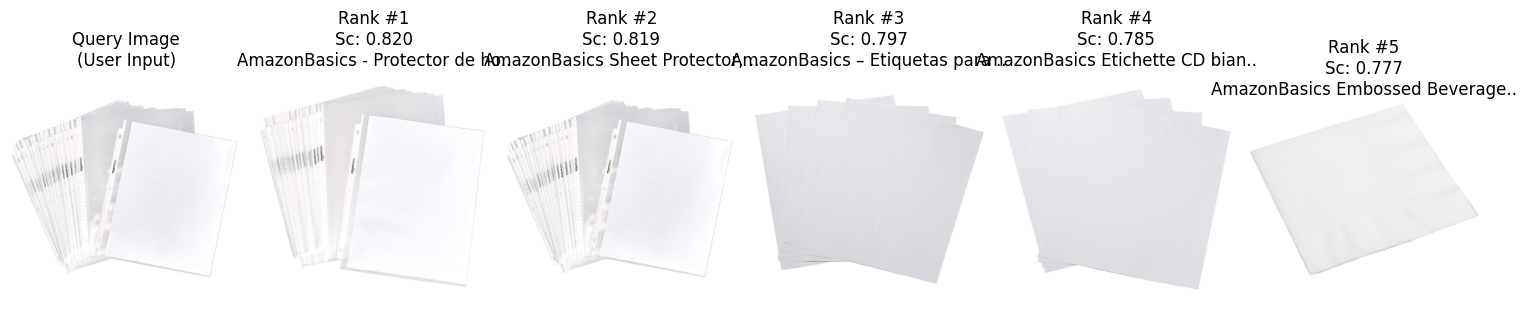

In [46]:
# 5. Test the Pipeline
# Let's take a random image from our dataset to simulate a "query"
sample_query_path = df_merged.sample(1).iloc[0]['full_path']
print(f"Testing with query image: {sample_query_path}")

search_products(str(sample_query_path), top_k=5)

# Step 5: Evaluation
Since we don't have a labeled "Ground Truth" test set for retrieval (i.e., we don't know exactly which product *should* be returned for a random photo), we will perform **Qualitative Evaluation**.

We will:
1.  Select a few distinct products (e.g., shoe, furniture, electronics).
2.  Run the Hybrid Search.
3.  Visually inspect if the Top-5 results are relevant.

Running Qualitative Evaluation on 3 samples...

--- Eval Query: [{'language_tag': 'en_IN', 'value': 'Amazon Brand - Solimo Designer Toy Car 3D Printed Hard Back Case Mobile Cover for Vivo Y27L'}] ---
Processing query: ../data/abo/images/original/01/0197b92d.jpg
Generated Description: 'a car on a pink and blue background phone case'

       TOP RESULTS


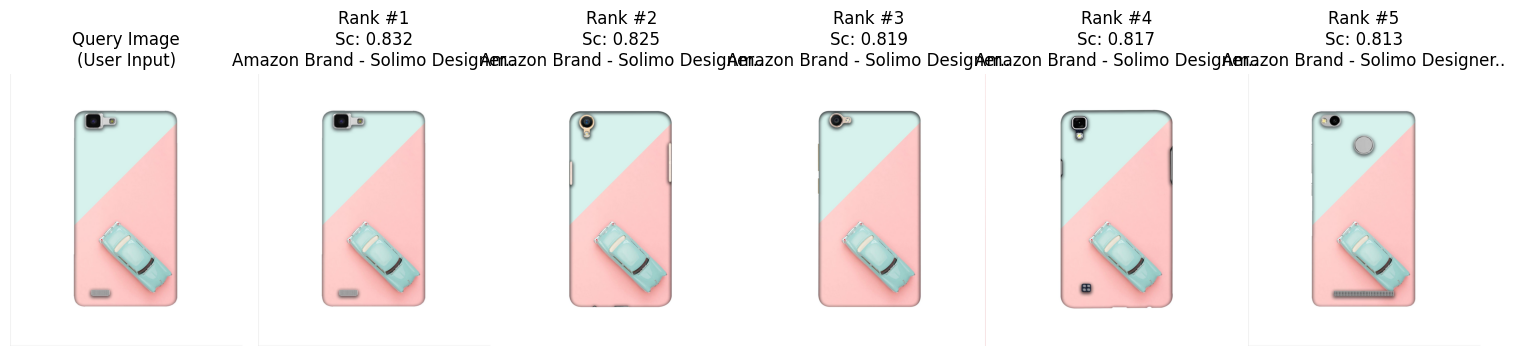

--- Eval Query: [{'language_tag': 'en_IN', 'value': 'Amazon Brand - Solimo Designer Flowers Photograpy 3D Printed Hard Back Case Mobile Cover for Samsung Galaxy J7 Duo'}] ---
Processing query: ../data/abo/images/original/14/146d503d.jpg
Generated Description: 'red flower samsung s6 phone case'

       TOP RESULTS


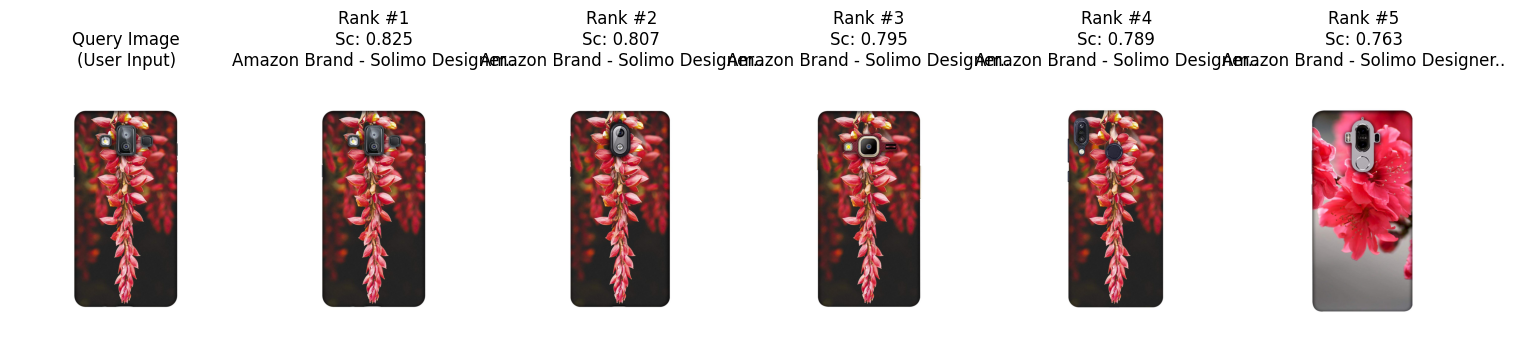

--- Eval Query: [{'language_tag': 'en_IN', 'value': 'Amazon Brand - Solimo Designer Heart Pattern Design 3D Printed Hard Back Case Mobile Cover for Oppo A5 (2020)'}] ---
Processing query: ../data/abo/images/original/15/15af50b3.jpg
Generated Description: 'pink hearts on black phone case'

       TOP RESULTS


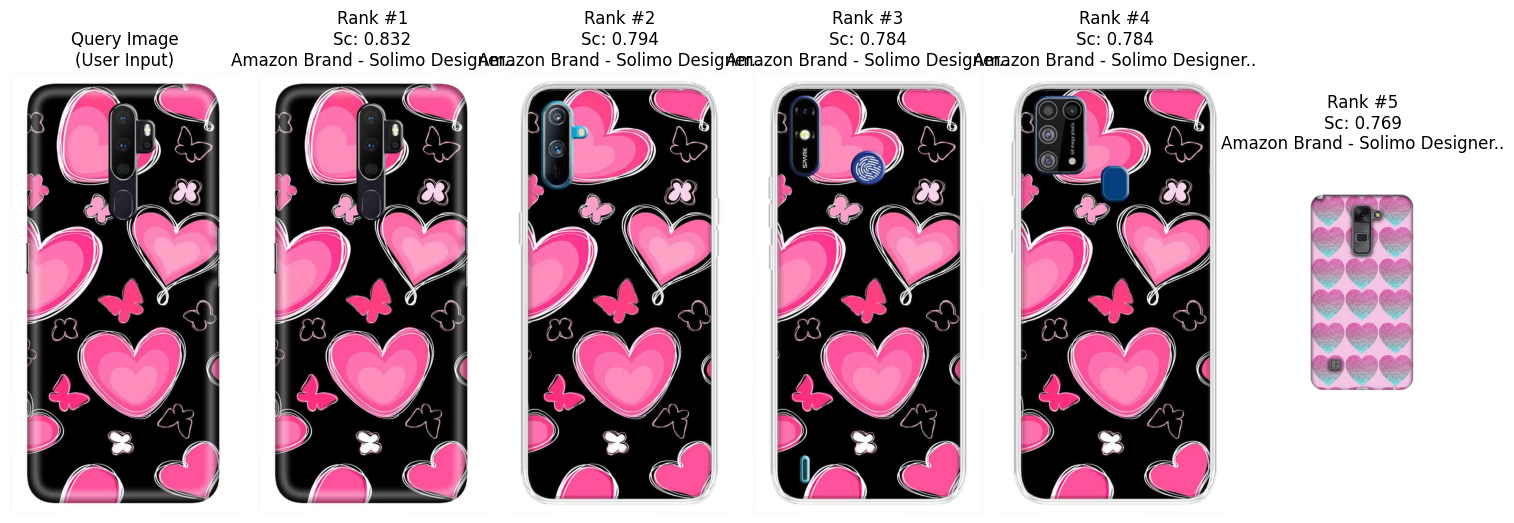

In [47]:
# Pick 3 random samples from different parts of the dataset to evaluate variety
# We'll try to pick samples that have different 'item_name' to ensure variety.

unique_products = df_merged.drop_duplicates(subset=['item_name'])
if len(unique_products) >= 3:
    test_samples = unique_products.sample(3)
else:
    test_samples = df_merged.sample(min(3, len(df_merged)))

print(f"Running Qualitative Evaluation on {len(test_samples)} samples...\n")

for idx, row in test_samples.iterrows():
    query_path = row['full_path']
    print(f"--- Eval Query: {row.get('item_name', 'Unknown')} ---")
    search_products(str(query_path), top_k=5)

### Quantitative Evaluation (Approximation)

To calculate **Precision@K** and **Recall@K**, we need "Ground Truth" (i.e., we need to know which images *should* be returned).

Since this is a catalog with unique products, we can define relevance in two ways:
1.  **Exact Product Match:** (If we had multiple images per product).
2.  **Category-Level Match:** (Did we return a *Shoe* when searching for a *Shoe*?).

Let's try **Category-Level Evaluation** using the `item_keywords` or `node` information if available in the listings. Or, we can simply rely on `item_id` if we happen to have multiple images of the same item (unlikely with just `main_image_id`).

Let's check if we have valid labels to evaluate against.

In [48]:
# Check relevant columns for ground truth
# 'product_type' or 'node' (category) would be good if available.
common_cols = [c for c in ['product_type', 'node', 'item_name', 'brand'] if c in df_merged.columns]
print(f"Potential columns for Ground Truth: {common_cols}")

if 'product_type' in df_merged.columns:
    label_col = 'product_type'
    print(f"Using '{label_col}' as class label.")
    
    # Display distribution
    print(df_merged[label_col].value_counts().head(10))
    
    # We can only evaluate categories that have at least 2 items (1 query, 1 match)
    valid_categories = df_merged[label_col].value_counts()
    valid_categories = valid_categories[valid_categories >= 2].index
    
    df_eval = df_merged[df_merged[label_col].isin(valid_categories)].copy()
    print(f"\nEval Set Size (Categories with >=2 items): {len(df_eval)}")
else:
    print("No obvious category column found. Cannot compute Category-Level P@K/R@K easily.")
    df_eval = pd.DataFrame() # Empty

Potential columns for Ground Truth: ['product_type', 'node', 'item_name', 'brand']
Using 'product_type' as class label.
product_type
[{'value': 'CELLULAR_PHONE_CASE'}]         8086
[{'value': 'SHOES'}]                       1608
[{'value': 'GROCERY'}]                      802
[{'value': 'HOME'}]                         584
[{'value': 'HOME_BED_AND_BATH'}]            320
[{'value': 'HOME_FURNITURE_AND_DECOR'}]     257
[{'value': 'SANDAL'}]                       254
[{'value': 'CHAIR'}]                        243
[{'value': 'BOOT'}]                         238
[{'value': 'FINERING'}]                     211
Name: count, dtype: int64

Eval Set Size (Categories with >=2 items): 18051


In [49]:
def calculate_metrics_at_k(embeddings, labels, k_values=[1, 5, 10]):
    """
    Simulated Image-to-Image Retrieval Evaluation.
    Query: One Image (embedding)
    Ground Truth: Other images with the SAME label (product_type)
    """
    if len(embeddings) < 2: return {}
    
    # Cosine Similarity Matrix (NxN)
    sim_matrix = embeddings @ embeddings.T
    
    # Mask self-matches (diagonal) so query doesn't match itself
    np.fill_diagonal(sim_matrix, -np.inf)
    
    n_samples = len(labels)
    # unique_labels = np.unique(labels) # Not strictly needed for calculation
    
    metrics = {f"P@{k}": [] for k in k_values}
    metrics.update({f"R@{k}": [] for k in k_values})
    
    # For every image in our eval set
    for i in tqdm(range(n_samples), desc="Evaluating P@K/R@K"):
        query_label = labels[i]
        
        # Get sorted indices of matches
        sorted_indices = np.argsort(sim_matrix[i])[::-1]
        
        # Evaluate for each K
        for k in k_values:
            top_k_indices = sorted_indices[:k]
            retrieved_labels = labels[top_k_indices]
            
            # Count matches
            n_relevant_retrieved = (retrieved_labels == query_label).sum()
            n_total_relevant = (labels == query_label).sum() - 1 # exclude self
            
            if n_total_relevant > 0:
                p_k = n_relevant_retrieved / k
                r_k = n_relevant_retrieved / n_total_relevant
                metrics[f"P@{k}"].append(p_k)
                metrics[f"R@{k}"].append(r_k)

    # Average
    avg_metrics = {k: np.mean(v) for k, v in metrics.items() if v}
    return avg_metrics

# -- Execute --
if not df_eval.empty:
    print("\nPreparing evaluation subset...")
    # Re-extract paths
    eval_paths = df_eval['full_path'].tolist()
    
    # CLEAN LABELS: Ensure they are strings, not dictionaries
    raw_labels = df_eval[label_col].values
    clean_labels = []
    for l in raw_labels:
        if isinstance(l, list) and len(l) > 0 and isinstance(l[0], dict):
             clean_labels.append(l[0].get('value', str(l)))
        elif isinstance(l, dict):
            clean_labels.append(l.get('value', str(l)))
        else:
            clean_labels.append(str(l))
            
    eval_labels = np.array(clean_labels)
    print(f"Sample clean labels: {eval_labels[:3]}")
    
    # We already computed embeddings for ALL images in 'image_embeddings'
    # We just need to index them correctly.
    # Map 'full_path' back to original index in df_merged
    path_to_idx = {p: i for i, p in enumerate(df_merged['full_path'])}
    eval_indices = [path_to_idx[p] for p in eval_paths]
    
    eval_embeddings = image_embeddings[eval_indices]
    
    print(f"Eval Set Shape: {eval_embeddings.shape}")
    
    # Calculate
    k_vals = [1, 5, 10]
    results = calculate_metrics_at_k(eval_embeddings, eval_labels, k_vals)
    
    print("\n--- Category-Level Retrieval Metrics ---")
    for k in k_vals:
        print(f"Precision@{k}: {results.get(f'P@{k}', 0):.4f} | Recall@{k}: {results.get(f'R@{k}', 0):.4f}")
else:
    print("Skipping evaluation: Not enough data per category.")


Preparing evaluation subset...
Sample clean labels: ['DRINKING_CUP' 'HARDWARE_HANDLE' 'CELLULAR_PHONE_CASE']
Eval Set Shape: (18051, 512)


Evaluating P@K/R@K: 100%|██████████| 18051/18051 [00:21<00:00, 853.18it/s]


--- Category-Level Retrieval Metrics ---
Precision@1: 0.8401 | Recall@1: 0.0103
Precision@5: 0.7875 | Recall@5: 0.0313
Precision@10: 0.7563 | Recall@10: 0.0469


# Step 6: Fine-Tuning (Optional)
To improve performance, we can fine-tune the CLIP model on our specific product images and titles.

**Strategy:** Contrastive Learning (InfoNCE Loss).
We will teach the model that *Image A* matches *Title A*, while pushing away *Title B, C, D...*

**Note:** This step requires training resources (GPU recommended). We will set up the loop for a few epochs as a demonstration.

In [66]:
# 1. Fine-Tuning Prerequisites: Dataset Class & Imports
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import torch.nn as nn

# FIX 5: Data Augmentation — random transforms to prevent memorization
from torchvision import transforms

train_augment = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
])

class ABODataset(Dataset):
    """
    Custom Dataset that returns (PIL Image, Title Text) pairs
    for contrastive fine-tuning of CLIP.
    Applies data augmentation to increase training variety.
    """
    def __init__(self, dataframe, processor, augment=None):
        self.df = dataframe.reset_index(drop=True)
        self.processor = processor
        self.augment = augment
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load Image
        try:
            image = Image.open(row['full_path']).convert("RGB")
            # Apply augmentation if provided
            if self.augment:
                image = self.augment(image)
        except Exception:
            # Return a blank image if loading fails
            image = Image.new("RGB", (224, 224), (0, 0, 0))
        
        # Get Title Text
        title = row.get('item_name', 'product')
        if isinstance(title, list):
            title = title[0].get('value', 'product') if title else 'product'
        elif not isinstance(title, str):
            title = 'product'
        
        # Truncate to CLIP's max token length
        title = title[:77]
        
        return image, title

print("Imports loaded: DataLoader, AdamW, nn")
print("ABODataset class defined.")

Imports loaded: DataLoader, AdamW, nn
ABODataset class defined.


In [67]:
# 2. Collate Function (Batches)
def collate_fn(batch):
    images = [item[0] for item in batch]
    texts = [item[1] for item in batch]
    
    # Process using CLIP Processor
    # This automatically tokenizes text and transforms images
    inputs = processor(
        text=texts, images=images, return_tensors="pt", padding=True, truncation=True, max_length=77
    )
    return inputs

# Setup DataLoader
# Use the full df_merged for real training
train_df = df_merged  # <--- CHANGED: Use full dataset
# train_df = df_merged.sample(min(len(df_merged), 500)) # Uncomment for quick demo

train_dataset = ABODataset(train_df, processor, augment=train_augment)
# Batch size can be increased if GPU memory allows (e.g., 16, 32)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

print(f"Training set size: {len(train_dataset)}")

Training set size: 18138


In [68]:
# 3. Fine-Tuning Function

# FIX 1: Freeze the image encoder — only fine-tune the text encoder
# This preserves CLIP's strong pre-trained visual features
for param in model.vision_model.parameters():
    param.requires_grad = False
for param in model.visual_projection.parameters():
    param.requires_grad = False

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"Trainable: {trainable:,} / {total:,} params ({100*trainable/total:.1f}%)")

def train_clip(model, dataloader, epochs=1):
    model.train()
    # FIX 2: Only optimize parameters that require gradients (text encoder)
    # FIX 3: Lower learning rate (1e-6 instead of 1e-5) for gentler updates
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-6)
    loss_img = nn.CrossEntropyLoss()
    loss_txt = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        loop = tqdm(dataloader, desc=f"Epoch {epoch+1}")
        total_loss = 0
        
        for batch in loop:
            # Move to device
            inputs = batch.to(device)
            
            optimizer.zero_grad()
            
            # Forward Pass: Compute both Image and Text features
            outputs = model(**inputs, return_loss=True)
            
            # CLIP Loss is computed internally if return_loss=True
            loss = outputs.loss
            
            # Backward Pass
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())
        
        print(f"Epoch {epoch+1} Average Loss: {total_loss / len(dataloader):.4f}")

# FIX 4: Reduce epochs (2 instead of 5) to avoid overfitting
print("Starting Fine-tuning loop...")
train_clip(model, train_loader, epochs=2)

print("Fine-tuning complete. The 'model' variable is now updated.")
# WARNING: This modifies the 'model' object in memory.
# If you run this, you must re-generate the index (Step 2) to use the new weights!

Trainable: 63,428,097 / 151,277,313 params (41.9%)
Starting Fine-tuning loop...


Epoch 1: 100%|██████████| 2268/2268 [08:44<00:00,  4.33it/s, loss=0.000272]


Epoch 1 Average Loss: 0.0772


Epoch 2: 100%|██████████| 2268/2268 [08:19<00:00,  4.54it/s, loss=1.58e-6] 

Epoch 2 Average Loss: 0.0529
Fine-tuning complete. The 'model' variable is now updated.


# Step 7: Re-Index with Fine-Tuned Model
After fine-tuning, the CLIP model weights have changed. The old `image_embeddings` were generated with the **pre-trained** weights and are now **stale**.

We must re-generate the embeddings using the updated model to see any improvement.

In [69]:
# Re-generate embeddings with the fine-tuned model
print("Re-generating embeddings with the fine-tuned CLIP model...")
model.eval()  # Switch back to eval mode

image_paths = df_merged['full_path'].tolist()
image_embeddings = generate_image_embeddings(image_paths, BATCH_SIZE)
print(f"New Embeddings Shape: {image_embeddings.shape}")
print("Index updated with fine-tuned weights.")

Re-generating embeddings with the fine-tuned CLIP model...


Encoding Images: 100%|██████████| 567/567 [04:19<00:00,  2.19it/s]

New Embeddings Shape: (18138, 512)
Index updated with fine-tuned weights.


# Step 8: Post-Fine-Tuning Evaluation
Let's re-run **both** qualitative search and quantitative metrics on the fine-tuned model to compare against the baseline.

=== Post-Fine-Tuning Search Results ===

Query: ../data/abo/images/original/10/10ccbb30.jpg
Processing query: ../data/abo/images/original/10/10ccbb30.jpg
Generated Description: 'a blue sectional couch with a chay chay'

       TOP RESULTS


/var/folders/t1/czw6fwgs7xx7z62mfl4ljxy00000gn/T/ipykernel_97362/2984943168.py:79: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/t1/czw6fwgs7xx7z62mfl4ljxy00000gn/T/ipykernel_97362/2984943168.py:79: UserWarning: Glyph 48307 (\N{HANGUL SYLLABLE BES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/t1/czw6fwgs7xx7z62mfl4ljxy00000gn/T/ipykernel_97362/2984943168.py:79: UserWarning: Glyph 50659 (\N{HANGUL SYLLABLE ES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/t1/czw6fwgs7xx7z62mfl4ljxy00000gn/T/ipykernel_97362/2984943168.py:79: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/t1/czw6fwgs7xx7z62mfl4ljxy00000gn/T/ipykernel_97362/2984943168.py:79: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/t1/czw6fwgs7xx7z62mfl4ljxy00000gn/T/ipykernel_

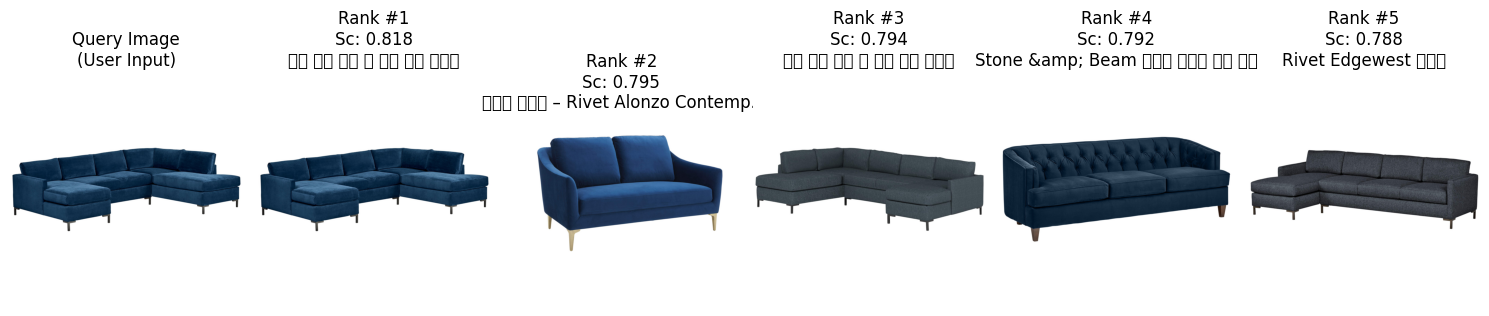

In [70]:
# A. Qualitative: Visual Search with Fine-Tuned Model
print("=== Post-Fine-Tuning Search Results ===\n")
sample_query_path = df_merged.sample(1).iloc[0]['full_path']
print(f"Query: {sample_query_path}")
search_products(str(sample_query_path), top_k=5)

In [71]:
# B. Quantitative: P@K / R@K with Fine-Tuned Model
if not df_eval.empty:
    # Re-compute eval embeddings from the updated index
    eval_indices_ft = [path_to_idx[p] for p in df_eval['full_path'].tolist()]
    eval_embeddings_ft = image_embeddings[eval_indices_ft]
    
    print(f"Eval Set Shape: {eval_embeddings_ft.shape}")
    
    k_vals = [1, 5, 10]
    results_ft = calculate_metrics_at_k(eval_embeddings_ft, eval_labels, k_vals)
    
    print("\n--- Post-Fine-Tuning Retrieval Metrics ---")
    for k in k_vals:
        print(f"Precision@{k}: {results_ft.get(f'P@{k}', 0):.4f} | Recall@{k}: {results_ft.get(f'R@{k}', 0):.4f}")
    
    # Compare with baseline
    print("\n--- Comparison (Baseline vs Fine-Tuned) ---")
    print(f"{'Metric':<12} {'Baseline':>10} {'Fine-Tuned':>12} {'Delta':>10}")
    print("-" * 46)
    for k in k_vals:
        for metric_type in ['P', 'R']:
            key = f"{metric_type}@{k}"
            base_val = results.get(key, 0)
            ft_val = results_ft.get(key, 0)
            delta = ft_val - base_val
            sign = "+" if delta >= 0 else ""
            print(f"{key:<12} {base_val:>10.4f} {ft_val:>12.4f} {sign}{delta:>9.4f}")
else:
    print("Skipping: No eval data available.")

Eval Set Shape: (18051, 512)


Evaluating P@K/R@K: 100%|██████████| 18051/18051 [00:20<00:00, 860.23it/s]


--- Post-Fine-Tuning Retrieval Metrics ---
Precision@1: 0.8162 | Recall@1: 0.0087
Precision@5: 0.7620 | Recall@5: 0.0247
Precision@10: 0.7331 | Recall@10: 0.0371

--- Comparison (Baseline vs Fine-Tuned) ---
Metric         Baseline   Fine-Tuned      Delta
----------------------------------------------
P@1              0.8401       0.8162   -0.0239
R@1              0.0103       0.0087   -0.0016
P@5              0.7875       0.7620   -0.0255
R@5              0.0313       0.0247   -0.0065
P@10             0.7563       0.7331   -0.0232
R@10             0.0469       0.0371   -0.0099


# Step 9: Production Search with FAISS
Replace brute-force numpy search with **FAISS (Facebook AI Similarity Search)** for scalable retrieval.

FAISS uses optimized C++ under the hood and can handle millions of vectors efficiently.

FAISS Index built: 18138 vectors, dim=512
Testing FAISS search with: ../data/abo/images/original/18/18b5b426.jpg

Caption: 'a white dog sitting in the grass on a sunny day'


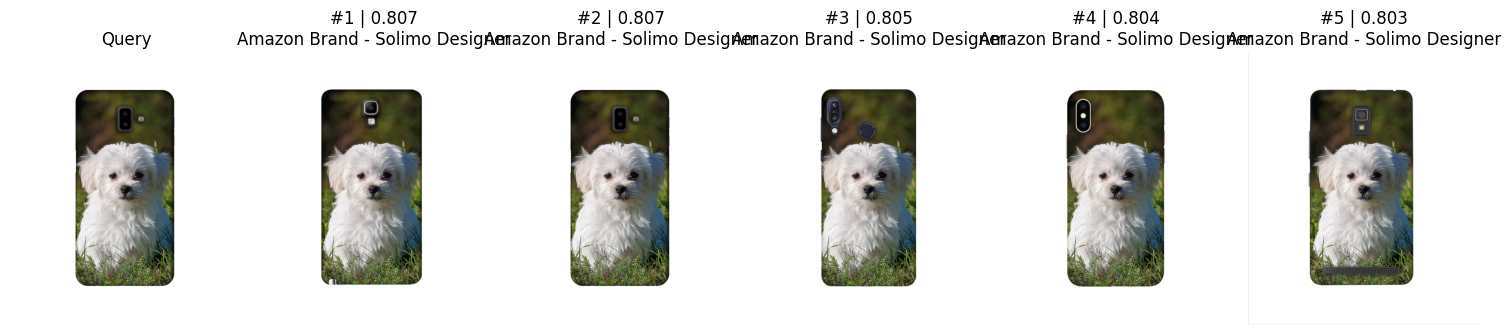

In [72]:
import faiss

# 1. Build FAISS Index
d = image_embeddings.shape[1]  # Dimension (512 for CLIP)
faiss_index = faiss.IndexFlatIP(d)  # Inner Product = Cosine Sim (for normalized vectors)
faiss_index.add(image_embeddings.astype('float32'))
print(f"FAISS Index built: {faiss_index.ntotal} vectors, dim={d}")

# 2. FAISS-powered Search Function
def search_faiss(query_image_path, top_k=5):
    """Search using FAISS instead of numpy for faster retrieval."""
    if not os.path.exists(query_image_path):
        print(f"File not found: {query_image_path}")
        return
    
    # Process query
    raw_image = Image.open(query_image_path).convert("RGB")
    caption = generate_caption(raw_image)
    print(f"Caption: '{caption}'")
    
    query_emb = get_hybrid_embedding(raw_image, caption).astype('float32')
    
    # FAISS search
    scores, indices = faiss_index.search(query_emb, top_k)
    scores, indices = scores[0], indices[0]
    
    # Display results
    fig, axes = plt.subplots(1, top_k + 1, figsize=(15, 5))
    axes[0].imshow(raw_image)
    axes[0].set_title("Query")
    axes[0].axis('off')
    
    for i, (score, idx) in enumerate(zip(scores, indices)):
        record = df_merged.iloc[idx]
        try:
            title = record.get('item_name', 'Unknown')
            if isinstance(title, list) and title:
                title = title[0].get('value', 'Unknown')
            title = str(title)[:30]
        except:
            title = "Unknown"
        
        try:
            img = Image.open(record['full_path']).convert("RGB")
            axes[i+1].imshow(img)
            axes[i+1].set_title(f"#{i+1} | {score:.3f}\n{title}")
            axes[i+1].axis('off')
        except:
            pass
    
    plt.tight_layout()
    plt.show()

# 3. Test FAISS Search
sample_path = df_merged.sample(1).iloc[0]['full_path']
print(f"Testing FAISS search with: {sample_path}\n")
search_faiss(str(sample_path), top_k=5)